In [1]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(42)

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import random

In [4]:
# config
numEpochs = 50 # number of epochs to train the GPT+PT model
embeddingSize = 512 # the hidden dimension of the representation of both GPT and PT
numPoints=20 # number of points that we are going to receive to make a prediction about f given x and y, if you don't know then use the maximum
numVars=2 # the dimenstion of input points x, if you don't know then use the maximum
numYs=1 # the dimension of output points y = f(x), if you don't know then use the maximum
blockSize = 100 # spatial extent of the model for its context
batchSize = 128 # batch size of training data
dataDir = 'D:/Datasets/Symbolic Dataset/Datasets'
dataInfo = 'XYE_{}Var_{}Points_{}EmbeddingSize'.format(numVars, numPoints, embeddingSize)
target = 'EQ' #'Skeleton' #'EQ'
dataFolder = '1-2Var_RandSupport_FixedLength_-1to4_4.1to8.0_benchmark_nguyenALL_NoConstants'
addr = './SavedModels/bestModel/' # where to save model
maxNumFiles = 30
bestLoss = None #0.142760 # NONE # if there is any model to load as pre-trained one

In [5]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, chars, target='EQ'):
        data_size, vocab_size = len(data), len(chars)
        print('data has %d examples, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        
        # padding token
        self.paddingToken = '_'
        self.paddingID = self.stoi[self.paddingToken]
        self.stoi[self.paddingToken] = self.paddingID
        self.itos[self.paddingID] = self.paddingToken
        self.threshold = [-1000,1000]
        
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data # it should be a list of examples
        self.target = target
    
    def __len__(self):
        return len(self.data)-1

    def __getitem__(self, idx):
        # grab an example from the data
        chunk = self.data[idx] # sequence of tokens including x, y, eq, etc.
        
        try:
            chunk = json.loads(chunk) # convert the sequence tokens to a dictionary
        except:
            print("Couldn't convert to json: {}".format(chunk))
            
        # encode every character in the equation to an integer
        # < is SOS, > is EOS
        dix = [self.stoi[s] for s in '<'+chunk[self.target]+'>']
        inputs = dix[:-1]
        outputs = dix[1:]
        
        # add the padding to the equations
        paddingSize = max(self.block_size-len(inputs),0)
        paddingList = [self.paddingID]*paddingSize
        inputs += paddingList
        outputs += paddingList 
        
        # make sure it is not more than what should be
        inputs = inputs[:self.block_size]
        outputs = outputs[:self.block_size]
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(zip(chunk['X'], chunk['Y'])):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=self.threshold[1], 
                                 neginf=self.threshold[0])
            p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
            p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
            points[:,idx] = p
        
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        inputs = torch.tensor(inputs, dtype=torch.long)
        outputs = torch.tensor(outputs, dtype=torch.long)
        return inputs, outputs, points


In [6]:
import json
from tqdm import tqdm
import glob
def processDataFiles(files):
    text = ''""
    for f in tqdm(files):
        with open(f, 'r') as h: 
            lines = h.read() # don't worry we won't run out of file handles
            if lines[-1]==-1:
                lines = lines[:-1]
            text += lines #json.loads(line)       
            
    return text

In [7]:
path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
chars = sorted(list(set(text))+['_','T','<','>']) # extract unique characters from the text before converting the text to a list
# T is for the test data
text = text.split('\n') # convert the raw text to a set of examples
text = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(text) # shuffle the dataset, it's important for combined number of variables
train_dataset = CharDataset(text, blockSize, chars, target=target) 

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.94it/s]


data has 100000 examples, 54 unique.


In [8]:
idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points = train_dataset.__getitem__(idx)
print('inputs:{}'.format(inputs))
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

inputs:tensor([22, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,  9, 11,  5, 50, 12,  4,  4,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34])
id:15795
inputs:<sqrt(abs(1.0*x1))__________________________________________________________________________________
outputs:sqrt(abs(1.0*x1))>__________________________________________________________________________________
points:tensor([[ 1.8535,  0.9868,  0.4910,  3.5687, -0.9755,  1.0919,  2.2073,  0.6608,
          2.9987,  0.7460,  0.7118,  2.7532,  1.1871,  3.3545,  1.1658,  3.9936,
          3.4541,  3.1069, -0.5287,  3.4882],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0

In [9]:
path = '{}/{}/Val/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textVal = processDataFiles([files[0]])
textVal = textVal.split('\n') # convert the raw text to a set of examples
val_dataset = CharDataset(textVal, blockSize, chars, target=target)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

data has 501 examples, 54 unique.


In [10]:
idx = np.random.randint(val_dataset.__len__())
inputs, outputs, points = val_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-5.2400) tensor(17.1987)
id:348
inputs:<1.0*x1**2+log(abs(1.0*x1))_________________________________________________________________________
outputs:1.0*x1**2+log(abs(1.0*x1))>_________________________________________________________________________
points:tensor([[ 3.2018e+00,  3.5402e+00, -5.1440e-01,  3.4885e+00,  2.2954e+00,
          1.5810e-01,  1.8348e+00,  4.2700e-02,  3.1115e+00,  1.5024e+00,
         -1.6000e-01,  2.5038e+00, -5.3000e-03,  2.9187e+00, -8.3200e-01,
          2.4626e+00,  3.9772e+00,  3.1835e+00,  1.4937e+00,  9.7710e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.1415e+01,  1.3797e+01, -4.0010e-01,  1.3419e+01,  6.0998e+00,
         -1.8195e+00,  3.9734e+00, -3.1517e+00,  1.0816e+01,  2.6643e

In [11]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles(files)
textTest = textTest.split('\n') # convert the raw text to a set of examples
# test_dataset_target = CharDataset(textTest, blockSize, chars, target=target)
test_dataset = CharDataset(textTest, blockSize, chars)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.63it/s]

data has 1001 examples, 54 unique.


In [87]:
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\ninputs:{}\noutputs:{}\npoints:{}'.format(idx,inputs,outputs,points))

tensor(-5.2032) tensor(10.6404)
id:700
inputs:<1.0*x1**2*sin(1.0*x2)______________________________________________________________________________
outputs:1.0*x1**2*sin(1.0*x2)>______________________________________________________________________________
points:tensor([[ 1.1076,  0.6758,  0.6545,  0.2084,  1.9271,  0.2503, -0.4701,  3.8629,
          0.5444,  3.2331,  2.4083, -0.5625,  1.5925,  2.2419,  2.2928,  0.3289,
          1.4028,  2.5990, -0.5180,  3.5673],
        [ 0.9163,  1.2089, -0.9606,  2.8221,  2.8042, -0.2761,  1.6844,  3.3713,
         -0.6228,  1.1527,  3.2686, -0.3074, -0.2099,  0.6658,  1.8370,  0.1565,
          3.2070, -0.8793,  0.4662,  0.9902],
        [ 0.9733,  0.4271, -0.3511,  0.0136,  1.2293, -0.0171,  0.2196, -3.3976,
         -0.1729,  9.5526, -0.7347, -0.0957, -0.5284,  3.1046,  5.0718,  0.0169,
         -0.1286, -5.2032,  0.1206, 10.6404]])


In [13]:
from mingpt.model import GPT, GPTConfig, PointNetConfig
pconf = PointNetConfig(embeddingSize=embeddingSize, 
                       numberofPoints=numPoints, 
                       numberofVars=numVars, 
                       numberofYs=numYs)
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=embeddingSize, padding_idx=train_dataset.paddingID)
model = GPT(mconf, pconf)

05/25/2021 03:00:57 - INFO - mingpt.model -   number of parameters: 3.058637e+07


In [14]:
fName = '{}_SymbolicGPT_{}_{}_{}_MINIMIZE.txt'.format(dataInfo, 
                                             'GPT_PT_Summation', 
                                             'Padding',
                                             blockSize)

In [15]:
ckptPath = '{}/{}.pt'.format(addr,fName.split('.txt')[0])
print(ckptPath)
if bestLoss != None:
    # load the best model
    model.load_state_dict(torch.load(ckptPath))

./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt


In [16]:
from mingpt.trainer import Trainer, TrainerConfig
import os

try: 
    os.mkdir(addr)
except:
    print('Folder already exists!')
    
# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=numEpochs, batch_size=batchSize, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=2*len(train_dataset)*blockSize,
                      num_workers=0, ckpt_path=ckptPath)
trainer = Trainer(model, train_dataset, val_dataset, tconf, bestLoss)

try:
    trainer.train()
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Folder already exists!


epoch 1 iter 781: train loss 0.21233. lr 3.002414e-04: 100%|█████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 03:06:34 - INFO - mingpt.trainer -   test loss: 0.180458
05/25/2021 03:06:34 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 2 iter 781: train loss 0.16505. lr 6.000000e-05: 100%|█████████████████████████| 782/782 [05:29<00:00,  2.38it/s]
05/25/2021 03:12:04 - INFO - mingpt.trainer -   test loss: 0.125897
05/25/2021 03:12:04 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 3 iter 760: train loss 0.18162. lr 2.880284e-04:  97%|████████████████████████▎| 761/782 [05:22<00:08,  2.37it/s]

Input:tensor([22, 48, 40, 43,  3, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  4,  4, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 40, 43,  3, 37, 50, 45,  3, 12,  9, 11,  5, 50, 12,  4,  4, 23, 48,
         3, 48, 12,  3, 12, 12, 12,  4, 12,  4, 12, 12,  4, 12,  4, 12, 12, 12,
        12, 12, 12, 12, 48, 12, 12, 12, 12, 12, 13,  4, 12, 12, 12, 48, 48, 12,
        13, 48, 12, 12, 12, 12, 12, 12, 12, 12, 48, 12, 12, 48, 48, 12, 12, 12,
        12, 48, 12, 12, 48, 12, 12, 12, 12, 12, 12, 13, 13,  4,  4, 12, 12, 12,
        13, 12,  3, 48, 12,  9, 12, 12, 12, 48], device='cuda:0')
Input:<sin(exp(1.0*x1))_________________________________

epoch 3 iter 781: train loss 0.20822. lr 3.002414e-04: 100%|█████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 03:17:36 - INFO - mingpt.trainer -   test loss: 0.223689
epoch 4 iter 781: train loss 0.26293. lr 5.999996e-04: 100%|█████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 03:23:10 - INFO - mingpt.trainer -   test loss: 0.244769
epoch 5 iter 781: train loss 0.15348. lr 2.992758e-04: 100%|█████████████████████████| 782/782 [05:33<00:00,  2.34it/s]
05/25/2021 03:28:45 - INFO - mingpt.trainer -   test loss: 0.175635
epoch 6 iter 40: train loss 0.12485. lr 2.745628e-04:   5%|█▍                         | 41/782 [00:17<05:35,  2.21it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12,  5,  5, 13,  5, 42, 44, 39,  3, 35, 36, 48,
         3, 12,  9, 11,  5, 50, 12,  4,  4,  6, 12,  9, 11,  5, 50, 12, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12,  5,  5, 13,  5, 48, 44, 39,  3, 35, 36, 48,  3,
        12,  9, 11,  5, 50, 12,  4,  4,  6, 12,  9, 11,  5, 50, 12, 23, 12, 44,
        12,  3, 44, 44,  3,  3, 12, 12, 13, 13,  5, 12, 12, 12, 23, 12,  3,  3,
        12,  3, 12, 12, 12, 35,  3, 35, 12, 49, 12,  3,  9, 12, 49, 12, 48,  3,
         9,  9, 12,  9, 12, 35, 49,  9,  9, 12, 12, 12, 12, 12,  9, 44,  4,  9,
        35, 49, 12,  9,  3, 12, 35, 12,  3,  9], device='cuda:0')
Input:<1.0*x1**2*log(abs(1.0*x1))+1.0*x1________________

epoch 6 iter 235: train loss 0.10172. lr 1.622204e-04:  30%|███████▌                 | 236/782 [01:41<03:51,  2.36it/s]

Input:tensor([22, 48, 40, 43,  3, 12,  9, 11,  5, 50, 12,  5,  5, 14,  4, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([48, 40, 43,  3, 12,  9, 11,  5, 50, 12,  5,  5, 14,  4, 23, 48, 48, 48,
        13, 40, 13, 49, 35,  4, 35,  4,  4,  9,  4,  4, 44, 46, 44, 46, 12, 44,
        44, 44, 35, 44, 44, 44, 44, 12, 12, 44, 12, 44, 44, 44, 49, 12, 48, 44,
        35, 48, 12,  9, 49, 35,  9, 48, 48, 48, 44, 48, 48, 48, 44, 49, 48, 48,
        48, 48,  4, 48, 48, 48,  3, 48,  9, 48,  4,  9, 48, 48, 12, 48, 44, 48,
        48,  3, 48, 44, 48, 12, 48, 48, 48,  9], device='cuda:0')
Input:<sin(1.0*x1**3)___________________________________

epoch 6 iter 781: train loss 0.14022. lr 6.000000e-05: 100%|█████████████████████████| 782/782 [05:34<00:00,  2.34it/s]
05/25/2021 03:34:20 - INFO - mingpt.trainer -   test loss: 0.109803
05/25/2021 03:34:20 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 7 iter 728: train loss 0.10500. lr 2.697304e-04:  93%|███████████████████████▎ | 728/782 [05:10<00:22,  2.38it/s]

Input:tensor([22, 12,  9, 11,  5, 50, 12, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([12,  9, 11,  5, 50, 12, 23, 48, 48, 40, 48, 48, 48, 48, 48, 48,  3, 43,
        43,  3,  3, 12, 47, 43,  4,  3, 47,  4, 12, 47, 48,  4,  4, 42, 48, 48,
        12, 12, 47, 48, 13,  4, 12, 12, 12,  4, 42, 46,  3, 47,  4, 42, 12,  4,
        49, 12, 12, 12, 42, 47, 12, 49, 49, 48, 49, 49, 47, 49, 13, 49,  4, 48,
        12,  4,  4, 12, 49, 49, 47, 47, 49,  4,  4,  4,  3, 48,  3,  4,  4,  3,
         4,  4, 49, 49,  3,  4, 12,  4,  4, 49], device='cuda:0')
Input:<1.0*x1___________________________________________

epoch 7 iter 781: train loss 0.25294. lr 3.012070e-04: 100%|█████████████████████████| 782/782 [05:32<00:00,  2.35it/s]
05/25/2021 03:39:53 - INFO - mingpt.trainer -   test loss: 0.102231
05/25/2021 03:39:53 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 8 iter 781: train loss 0.17368. lr 5.999965e-04: 100%|█████████████████████████| 782/782 [05:33<00:00,  2.35it/s]
05/25/2021 03:45:28 - INFO - mingpt.trainer -   test loss: 0.267881
epoch 9 iter 781: train loss 0.11238. lr 2.983102e-04: 100%|█████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 03:51:00 - INFO - mingpt.trainer -   test loss: 0.147890
epoch 10 iter 741: train loss 0.07983. lr 6.000000e-05:  95%|██████████████████████▊ | 742/782 [05:13<00:16,  2.38it/s]

Input:tensor([22, 42, 44, 39,  3, 35, 36, 48,  3, 48, 46, 47, 49,  3, 35, 36, 48,  3,
        12,  9, 11,  5, 50, 13,  4,  4,  4,  4, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
        34, 34, 34, 34, 34, 34, 34, 34, 34, 34], device='cuda:0')
Logit:tensor([42, 44, 39,  3, 35, 36, 48,  3, 48, 46, 47, 49,  3, 35, 36, 48,  3, 12,
         9, 11,  5, 50, 13,  4,  4,  4,  4, 23, 48, 13, 13, 13, 13, 13, 13, 44,
        13, 13, 46,  4, 46, 48, 23, 40, 23, 23,  4, 42,  3, 23, 35, 44, 23,  3,
        23,  3, 44, 35, 35, 35, 35, 35, 35, 42, 35, 35, 35, 35, 35, 35,  3, 35,
        35,  3, 35, 35, 47, 35, 35, 35,  3,  3,  3, 35, 35, 35, 35,  3, 35, 35,
         3, 35, 35, 35,  3, 35,  3,  3, 35, 35], device='cuda:0')
Input:<log(abs(sqrt(abs(1.0*x2))))______________________

epoch 10 iter 781: train loss 0.07840. lr 6.000000e-05: 100%|████████████████████████| 782/782 [05:30<00:00,  2.37it/s]
05/25/2021 03:56:31 - INFO - mingpt.trainer -   test loss: 0.113856
epoch 11 iter 781: train loss 0.11619. lr 3.021726e-04: 100%|████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 04:02:04 - INFO - mingpt.trainer -   test loss: 0.058541
05/25/2021 04:02:04 - INFO - mingpt.trainer -   saving ./SavedModels/bestModel//XYE_2Var_20Points_512EmbeddingSize_SymbolicGPT_GPT_PT_Summation_Padding_100_MINIMIZE.pt
epoch 12 iter 781: train loss 0.14210. lr 5.999903e-04: 100%|████████████████████████| 782/782 [05:31<00:00,  2.36it/s]
05/25/2021 04:07:36 - INFO - mingpt.trainer -   test loss: 0.167606
epoch 13 iter 320: train loss 0.08357. lr 5.381349e-04:  41%|█████████▊              | 321/782 [02:18<03:18,  2.32it/s]

KeyboardInterrupt


In [17]:
# load the best model
model.load_state_dict(torch.load(ckptPath))
model = model.eval().to(trainer.device)

In [18]:
# add a safe wrapper for numpy math functions
from numpy import *
import numpy as np

def divide(x, y):
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)
  return np.divide(x,y+1e-5)

def sqrt(x):
  x = np.nan_to_num(x)
  return np.sqrt(np.abs(x)) 

# Mean square error
def mse(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        our_sum += (y_hat[i] - y_gold[i]) ** 2

    return our_sum / len(y_gold)

# Mean square error
def relativeErr(y, y_hat):
    y_hat = np.reshape(y_hat, [1, -1])[0]
    y_gold = np.reshape(y, [1, -1])[0]
    our_sum = 0
    for i in range(len(y_gold)):
        if y_gold[i] < 1: 
            # use regular MSE
            our_sum += (y_hat[i] - y_gold[i]) ** 2
        else:
            # use relative MSE
            our_sum += ((y_hat[i] - y_gold[i])/y_gold[i]) ** 2

    return our_sum / len(y_gold)

In [19]:
# class pointsDataset(Dataset):

#     def __init__(self, data):
#         # data should be a list of x,y pairs
#         self.x = data[0] # it should be a list
#         self.y = data[1] # it should be a list
#         self.threshold = [-1000,1000]
    
#     def __len__(self):
#         return len(self.y)

#     def __getitem__(self, idx):
#         # grab an example from the data
#         x = self.x[idx] 
#         y = self.y[idx] 
        
#         p = x+[y]
        
#         p = torch.tensor(p, dtype=torch.float)
#         p = torch.nan_to_num(p, nan=0.0, 
#                              posinf=self.threshold[1], 
#                              neginf=self.threshold[0])
#         p[p>self.threshold[1]] = self.threshold[1] # clip the upper bound
#         p[p<self.threshold[0]] = self.threshold[0] # clip the lower bound
        
#         return p
    
# # train a mlp to find the constants
# data = pointsDataset((t['X'],t['Y']))
# loader = torch.utils.data.DataLoader(
#                                 data, 
#                                 shuffle=False, 
#                                 pin_memory=True,
#                                 batch_size=batchSize,
#                                 num_workers=0)
# class MLP(nn.Module):
#     def __init__(self, inputSize, outputSize):
#         super().__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(inputSize, 100),
#             nn.ReLU(),
#             nn.Linear(100, outputSize)
#         )

#     def forward(self, x):
#         c = self.layers(x)
#         return c
    
#     def loss(self, constants, eq, X, Y):
#         # constants is the output of the model
#         err = torch.zeros(len(constants)) # batch_size
        
#         # sample number of points
#         indexes = []
#         numberSamples = 10
#         while len(indexes) != numberSamples:
#             randNum = np.random.randint(len(batch))
#             indexes.append(randNum)
#         X = X[indexes,:]
#         Y = Y[indexes,:]
        
#         # replace the constants with their predicted values
#         for idx, const in enumerate(constants):
#             eq = eq.replace('C','{}').format(*const.tolist())
        
#         # calculate the error for a limited number of points, approximate the error
#         for x,y in zip(X,Y):
#             # replace variables with their values
#             for i,e in enumerate(x):
#                 eqTemp = eq.replace('x{}'.format(i+1), str(e.item()))
                
#             # calculate the error
#             yHat = eval(eqTemp)
#             err[idx] += (y.item()-yHat)**2
#         err[idx] /= numberSamples
            
#         print(err.shape, constants.shape)
#         return err
    
# c = [0 for i,x in enumerate(predicted) if x=='C']
# network = MLP(numVars+numYs, len(c))
# cHat = network(batch)
# err = network.loss(cHat, predicted, batch[:,:numVars], batch[:,-numYs:])

In [20]:
# alright, let's sample some character-level symbolic GPT
from mingpt.utils import sample
from gp_model import Genetic_Model
from mlp_model import MLP_Model
from scipy.optimize import least_squares, newton, minimize

    
loader = torch.utils.data.DataLoader(
                                test_dataset, 
                                shuffle=False, 
                                pin_memory=True,
                                batch_size=1,
                                num_workers=0)

testRange = [3.1,6.0]
numTestPoints = 10
#test = np.linspace(3.1,6.0,numTestPoints)

gpm = Genetic_Model(n_jobs=-1)
mlp = MLP_Model()

resultDict = {}
try:
    with open(fName, 'w', encoding="utf-8") as o:
        modelName = 'SymbolicGPT'
        resultDict[fName] = {modelName:[],
                             'GP':[],
                             'MLP':[]}

        for i, batch in enumerate(loader):
                
            inputs,outputs,points = batch

            print('Test Case {}.'.format(i))
            o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

            t = json.loads(textTest[i])

            inputs = inputs[:,0:1].to(trainer.device)
            points = points.to(trainer.device)
            outputsHat = sample(model, inputs, blockSize, points=points,
                          temperature=1.0, sample=True, 
                          top_k=40)[0]

            # filter out predicted
            target = ''.join([train_dataset.itos[int(i)] for i in outputs[0]])
            predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])

            target = target.strip(train_dataset.paddingToken).split('>')
            target = target[0] if len(target[0])>=1 else target[1]
            target = target.strip('<').strip(">")
            predicted = predicted.strip(train_dataset.paddingToken).split('>')
            predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
            predicted = predicted.strip('<').strip(">")
            
            print('Target:{}\nSkeleton:{}'.format(target, predicted))
            
            o.write('{}\n'.format(target))
            o.write('{}:\n'.format(modelName))
            o.write('{}\n'.format(predicted))

            # train a regressor to find the constants (too slow)
            c = [1 for i,x in enumerate(predicted) if x=='C']            
            def lossFunc(constants, eq, X, Y):
                err = 0
                eq = eq.replace('C','{}').format(*constants)

                for x,y in zip(X,Y):
                    eqTemp = eq + ''
                    for i,e in enumerate(x):
                        eqTemp = eqTemp.replace('x{}'.format(i+1), str(e))
                    try:
                        yHat = eval(eqTemp)
                    except:
                        yHat = 100
                    err += (y-yHat)**2
                err /= len(Y)
                return err
            
            try:
                if len(c) == 0:
                    pass # do nothing
                else:
#                     cHat = least_squares(lossFunc, c, ftol=1e-3,
#                                          args=(predicted, t['X'], t['Y']))
                    
                    # for easier comparison, we are using minimize package  
                    cHat = minimize(lossFunc, c,
                                   args=(predicted, t['X'], t['Y'])) 
            
#                     cHat= newton(lossFunc, c, maxiter=100,
#                                  args=(predicted, t['X'], t['Y']))
                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except:
                print('Wrong Equation:{}'.format(predicted))
                raise
                predicted = 0

            # TODO: let's enjoy GPU

            print('Skeleton+LS:{}'.format(predicted))

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = target + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    YEval = eval(eqTmp)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats)

            if type(err) is np.complex128 or np.complex:
                err = abs(err.real)

            resultDict[fName][modelName].append(err)

            o.write('{}\n{}\n\n'.format( 
                                    predicted,
                                    err
                                    ))

            print('Err:{}'.format(err))
            
            # Calculate error for baselines

    #         # tokenize to get input x, input y, and true eqn
    #         train_data_x = t["X"]
    #         train_data_y = t["Y"]
    #         test_data_x = t["XT"]
    #         test_data_y = t["YT"]

    #         # train MLP model
    #         mlp.reset()
    #         model_eqn, _, best_err = mlp.repeat_train(
    #                                                 train_data_x, 
    #                                                 train_data_y,
    #                                                 test_x=test_data_x, 
    #                                                 test_y=test_data_y,                                     
    #                                                 verbose=False)
    #         test_y_hat = mlp.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("{}: {}".format(mlp.name, model_eqn)[:550])
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['MLP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('MLP', 
    #                                    err,
    #                                    model_eqn))

    #         # train GP model
    #         gpm.reset()
    #         model_eqn, _, best_err = gpm.repeat_train(train_data_x, train_data_y,
    #                                                 test_x=test_data_x, test_y=test_data_y,
    #                                                 verbose=False)
    #         print("{}: {}".format(gpm.name, model_eqn)[:550])
    #         test_y_hat = gpm.predict(test_data_x)
    #         err = relativeErr(test_data_y,test_y_hat)
    #         print("Err: {:.5f}".format(err))
    #         resultDict[fName]['GP'].append(err)
    #         o.write('\n{}: {}\n{}'.format('GP', 
    #                                    err,
    #                                    model_eqn))
            print('') # just an empty line
    print('Avg Err:{}'.format(np.mean(resultDict[fName][modelName])))
    
except KeyboardInterrupt:
    print('KeyboardInterrupt')

Test Case 0.
Target:1.0*x1**4*sin(1.0*x1)
Skeleton:1.0*x1**4*sin(1.0*x1)
Skeleton+LS:1.0*x1**4*sin(1.0*x1)
Err:0.0

Test Case 1.
Target:1.0*x1
Skeleton:1.0*x1
Skeleton+LS:1.0*x1
Err:0.0

Test Case 2.
Target:sqrt(abs(1.0*x1))*exp(1.0*x1)*exp(sin(1.0*x1))
Skeleton:4.0*x1**2+1.0*x1*sin(1.0*x1)
Skeleton+LS:4.0*x1**2+1.0*x1*sin(1.0*x1)
Err:0.551186594594461

Test Case 3.
Target:1.0*x1**2*exp(exp(1.0*x1))
Skeleton:1.0*x1**2*exp(2.0*x1)
Skeleton+LS:1.0*x1**2*exp(2.0*x1)
Err:2929751049774.498

Test Case 4.


C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


Target:1.0*x1**2*sin(1.0*x1**2)
Skeleton:1.0*x1**2*sin(1.0*x1**2)
Skeleton+LS:1.0*x1**2*sin(1.0*x1**2)
Err:0.0

Test Case 5.
Target:1.0*x1**2
Skeleton:1.0*x1**2
Skeleton+LS:1.0*x1**2
Err:0.0

Test Case 6.
Target:exp(sqrt(abs(1.0*x1)))
Skeleton:exp(sqrt(abs(1.0*x1)))
Skeleton+LS:exp(sqrt(abs(1.0*x1)))
Err:0.0

Test Case 7.
Target:1.0*x1**6
Skeleton:1.0*x1**6
Skeleton+LS:1.0*x1**6
Err:0.0

Test Case 8.
Target:1.0*x1**2
Skeleton:sqrt(abs(1.0*x1**4))
Skeleton+LS:sqrt(abs(1.0*x1**4))
Err:2.0481830261180086e-33

Test Case 9.
Target:1.0*x1**6
Skeleton:1.0*x1**6
Skeleton+LS:1.0*x1**6
Err:0.0

Test Case 10.
Target:1.0*x1**2*sqrt(abs(2.0*x1))*sin(1.0*x1)
Skeleton:1.0*x1**2*sqrt(abs(1.0*x1**2))*sin(1.0*x1)
Skeleton+LS:1.0*x1**2*sqrt(abs(1.0*x1**2))*sin(1.0*x1)
Err:532.0124696199256

Test Case 11.
Target:2.0*x1**2
Skeleton:1.0*x1**3+1.0*x1
Skeleton+LS:1.0*x1**3+1.0*x1
Err:4.471838030875496

Test Case 12.
Target:exp(1.0*x1)
Skeleton:exp(1.0*x1)
Skeleton+LS:exp(1.0*x1)
Err:0.0

Test Case 13.
Target:

Target:1.0*x1**2*log(abs(1.0*x1))*log(abs(1.0*x1**2))
Skeleton:1.0*x1**2*sqrt(abs(1.0*x1))*log(abs(1.0*x1))**2
Skeleton+LS:1.0*x1**2*sqrt(abs(1.0*x1))*log(abs(1.0*x1))**2
Err:0.06856604184237225

Test Case 75.
Target:sin(1.0*x1)
Skeleton:sin(1.0*x1)
Skeleton+LS:sin(1.0*x1)
Err:0.0

Test Case 76.
Target:sin(1.0*x1**2)
Skeleton:sin(1.0*x1**2)
Skeleton+LS:sin(1.0*x1**2)
Err:0.0

Test Case 77.
Target:log(abs(sqrt(abs(1.0*x1**2))))
Skeleton:log(abs(1.0*x1))
Skeleton+LS:log(abs(1.0*x1))
Err:0.0

Test Case 78.
Target:1.0*x1**2*sqrt(abs(1.0*x1))+exp(1.0*x1**2)
Skeleton:exp(1.0*x1**2)
Skeleton+LS:exp(1.0*x1**2)
Err:5.335655159109199e-14

Test Case 79.
Target:1.0*x1**2
Skeleton:sqrt(abs(1.0*x1**4))
Skeleton+LS:sqrt(abs(1.0*x1**4))
Err:3.903570852490475e-33

Test Case 80.
Target:1.0*x1**4
Skeleton:1.0*x1**4
Skeleton+LS:1.0*x1**4
Err:0.0

Test Case 81.
Target:1.0*x1**3
Skeleton:1.0*x1**3
Skeleton+LS:1.0*x1**3
Err:0.0

Test Case 82.
Target:1.0*x1**3*exp(1.0*x1)
Skeleton:1.0*x1**2*abs(1.0*x1)*exp(1.

Target:1.0*x1*sqrt(abs(1.0*x1))*exp(1.0*x1)
Skeleton:1.0*x1*sqrt(abs(1.0*x1**2))*exp(1.0*x1)
Skeleton+LS:1.0*x1*sqrt(abs(1.0*x1**2))*exp(1.0*x1)
Err:2.076118910053633

Test Case 137.
Target:sqrt(abs(2.0*x1**2))
Skeleton:sqrt(abs(1.0*x1**2))
Skeleton+LS:sqrt(abs(1.0*x1**2))
Err:0.08578643762690492

Test Case 138.
Target:1.0*x1*exp(1.0*x1)
Skeleton:1.0*x1*exp(1.0*x1)
Skeleton+LS:1.0*x1*exp(1.0*x1)
Err:0.0

Test Case 139.
Target:1.0*x1**2*exp(1.0*x1)*sin(1.0*x1)
Skeleton:1.0*x1**5*sin(1.0*x1)
Skeleton+LS:1.0*x1**5*sin(1.0*x1)
Err:861867.8362429256

Test Case 140.
Target:exp(1.0*x1)*sin(1.0*x1**2)
Skeleton:2.0*x1**2*sin(2.0*x1)
Skeleton+LS:2.0*x1**2*sin(2.0*x1)
Err:600897.4414097482

Test Case 141.
Target:exp(exp(1.0*x1)*log(abs(1.0*x1)))
Skeleton:exp(exp(1.0*x1)*log(abs(1.0*x1))))
Skeleton+LS:exp(exp(1.0*x1)*log(abs(1.0*x1))))
Err:0.35

Test Case 142.
Target:log(abs(1.0*x1**2))
Skeleton:log(abs(1.0*x1**2))
Skeleton+LS:log(abs(1.0*x1**2))
Err:0.0

Test Case 143.
Target:1.0*x1**3+1.0*x1**2


Target:1.0*x1**2*log(abs(1.0*x1))
Skeleton:1.0*x1**2*log(abs(1.0*x1))
Skeleton+LS:1.0*x1**2*log(abs(1.0*x1))
Err:0.0

Test Case 203.
Target:1.0*x1**4
Skeleton:1.0*x1**4
Skeleton+LS:1.0*x1**4
Err:0.0

Test Case 204.
Target:sin(1.0*x1**2*exp(1.0*x1))
Skeleton:sin(1.0*x1**2)
Skeleton+LS:sin(1.0*x1**2)
Err:0.9455238576431736

Test Case 205.
Target:log(abs(1.0*x1))**2*sin(1.0*x1)
Skeleton:sin(exp(1.0*x1))
Skeleton+LS:sin(exp(1.0*x1))
Err:4.365567617476932

Test Case 206.
Target:1.0*x1**2*exp(1.0*x1)+sin(1.0*x1)
Skeleton:1.0*x1**4+1.0*x1**2*exp(sin(1.0*x1))
Skeleton+LS:1.0*x1**4+1.0*x1**2*exp(sin(1.0*x1))
Err:0.7905460327477682

Test Case 207.
Target:1.0*x1**4*sin(1.0*x1)
Skeleton:1.0*x1**4*sin(1.0*x1)
Skeleton+LS:1.0*x1**4*sin(1.0*x1)
Err:0.0

Test Case 208.
Target:1.0*x1**4*sqrt(abs(1.0*x1))
Skeleton:1.0*x1**4*sqrt(abs(1.0*x1))
Skeleton+LS:1.0*x1**4*sqrt(abs(1.0*x1))
Err:0.0

Test Case 209.
Target:log(abs(exp(1.0*x1)))
Skeleton:1.0*x1
Skeleton+LS:1.0*x1
Err:0.0

Test Case 210.
Target:log(a

Target:1.0*x1*sqrt(abs(log(abs(1.0*x1))))
Skeleton:1.0*x1*log(abs(1.0*x1))**2
Skeleton+LS:1.0*x1*log(abs(1.0*x1))**2
Err:2.0985942820220225

Test Case 271.
Target:1.0*x1**2
Skeleton:1.0*x1**2
Skeleton+LS:1.0*x1**2
Err:0.0

Test Case 272.
Target:1.0*x1**2+sqrt(abs(1.0*x1))+log(abs(1.0*x1))
Skeleton:2.0*x1*log(abs(1.0*x1))+1.0*x1
Skeleton+LS:2.0*x1*log(abs(1.0*x1))+1.0*x1
Err:0.10207760244399806

Test Case 273.
Target:exp(sin(1.0*x1**2))
Skeleton:exp(sin(1.0*x1**2))
Skeleton+LS:exp(sin(1.0*x1**2))
Err:0.0

Test Case 274.
Target:sin(1.0*x1)
Skeleton:sin(1.0*x1)**2
Skeleton+LS:sin(1.0*x1)**2
Err:1.4712238159269535

Test Case 275.
Target:sqrt(abs(1.0*x1**2))
Skeleton:sqrt(abs(1.0*x1**2))
Skeleton+LS:sqrt(abs(1.0*x1**2))
Err:0.0

Test Case 276.
Target:1.0*x1**4*exp(1.0*x1)
Skeleton:1.0*x1**2*sqrt(abs(1.0*x1))*exp(1.0*x1**2)
Skeleton+LS:1.0*x1**2*sqrt(abs(1.0*x1))*exp(1.0*x1**2)
Err:1.7526055516340235e+43

Test Case 277.
Target:1.0*x1**2+sin(1.0*x1)
Skeleton:1.0*x1**2+1.0*x1
Skeleton+LS:1.0*x

Target:1.0*x1**3
Skeleton:1.0*x1**3
Skeleton+LS:1.0*x1**3
Err:0.0

Test Case 344.
Target:exp(1.0*x1)*sin(1.0*x1**2)
Skeleton:1.0*x1**3*sin(1.0*x1**2)+sqrt(abs(1.0*x1))
Skeleton+LS:1.0*x1**3*sin(1.0*x1**2)+sqrt(abs(1.0*x1))
Err:115313.09852737754

Test Case 345.
Target:1.0*x1**2
Skeleton:1.0*x1**2
Skeleton+LS:1.0*x1**2
Err:0.0

Test Case 346.
Target:1.0*x1**3*sqrt(abs(1.0*x1))
Skeleton:1.0*x1**3*sqrt(abs(1.0*x1))
Skeleton+LS:1.0*x1**3*sqrt(abs(1.0*x1))
Err:0.0

Test Case 347.
Target:2.0*x1*exp(1.0*x1**2)
Skeleton:3.0*x1*exp(1.0*x1**2)
Skeleton+LS:3.0*x1*exp(1.0*x1**2)
Err:0.24999999999999994

Test Case 348.
Target:1.0*x1**2
Skeleton:1.0*x1**2
Skeleton+LS:1.0*x1**2
Err:0.0

Test Case 349.
Target:1.0*x1*sqrt(abs(1.0*x1))*log(abs(1.0*x1))
Skeleton:1.0*x1*sqrt(abs(1.0*x1))*log(abs(1.0*x1))
Skeleton+LS:1.0*x1*sqrt(abs(1.0*x1))*log(abs(1.0*x1))
Err:0.0

Test Case 350.
Target:sqrt(abs(sqrt(abs(1.0*x1**2))))
Skeleton:sqrt(abs(1.0*x1))
Skeleton+LS:sqrt(abs(1.0*x1))
Err:0.0

Test Case 351.
Target

Target:1.0*x1**3+1.0*x1
Skeleton:1.0*x1**2*sqrt(abs(1.0*x1**2))
Skeleton+LS:1.0*x1**2*sqrt(abs(1.0*x1**2))
Err:0.0010845986562878595

Test Case 411.
Target:log(abs(1.0*x1))
Skeleton:log(abs(1.0*x1))
Skeleton+LS:log(abs(1.0*x1))
Err:0.0

Test Case 412.
Target:1.0*x1**2+1.0*x1
Skeleton:1.0*x1**2+1.0*x1
Skeleton+LS:1.0*x1**2+1.0*x1
Err:0.0

Test Case 413.
Target:2.0*x1**5+2.0*x1
Skeleton:4.0*x1**4
Skeleton+LS:4.0*x1**4
Err:0.46162059523591326

Test Case 414.
Target:1.0*x1**2*log(abs(1.0*x1))*sin(1.0*x1)
Skeleton:log(abs(1.0*x1**2))*sin(1.0*x1)
Skeleton+LS:log(abs(1.0*x1**2))*sin(1.0*x1)
Err:300.14904946690336

Test Case 415.
Target:1.0*x1**2*log(abs(sin(1.0*x1)))
Skeleton:1.0*x1**2+1.0*x1*log(abs(sin(1.0*x1)))
Skeleton+LS:1.0*x1**2+1.0*x1*log(abs(sin(1.0*x1)))
Err:4792.550476386068

Test Case 416.
Target:2.0*x1**3+1.0*x1
Skeleton:2.0*x1**3
Skeleton+LS:2.0*x1**3
Err:0.0002437552607343

Test Case 417.
Target:sin(1.0*x1**2+sin(1.0*x1))
Skeleton:sin(1.0*x1**2+1.0*x1**2)
Skeleton+LS:sin(1.0*x1

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars


Target:exp(2.0*x1)
Skeleton:exp(2.0*x1)
Skeleton+LS:exp(2.0*x1)
Err:0.0

Test Case 452.
Target:1.0*x1**4
Skeleton:1.0*x1**4
Skeleton+LS:1.0*x1**4
Err:0.0

Test Case 453.
Target:1.0*x1**2*sin(1.0*x1)
Skeleton:1.0*x1**2*sin(1.0*x1)
Skeleton+LS:1.0*x1**2*sin(1.0*x1)
Err:0.0

Test Case 454.
Target:2.0*x1**2
Skeleton:2.0*x1**2
Skeleton+LS:2.0*x1**2
Err:0.0

Test Case 455.
Target:sqrt(abs(exp(sin(1.0*x1))))
Skeleton:sqrt(abs(sqrt(abs(exp(1.0*x1)))))
Skeleton+LS:sqrt(abs(sqrt(abs(exp(1.0*x1)))))
Err:9.477316385270175

Test Case 456.
Target:1.0*x1**3
Skeleton:1.0*x1**3
Skeleton+LS:1.0*x1**3
Err:0.0

Test Case 457.
Target:2.0*x1*sqrt(abs(1.0*x1))
Skeleton:1.0*x1*sqrt(abs(exp(1.0*x1)))
Skeleton+LS:1.0*x1*sqrt(abs(exp(1.0*x1)))
Err:17.461734053262553

Test Case 458.
Target:sqrt(abs(sqrt(abs(1.0*x1))))*exp(1.0*x1)
Skeleton:exp(1.0*x1)*sin(sqrt(abs(1.0*x1))))
Skeleton+LS:exp(1.0*x1)*sin(sqrt(abs(1.0*x1))))
Err:0.578686229971291

Test Case 459.
Target:sqrt(abs(1.0*x1**2+2.0*x1))
Skeleton:sqrt(abs(1.

Target:log(abs(log(abs(1.0*x1))))
Skeleton:log(abs(log(abs(1.0*x1))))
Skeleton+LS:log(abs(log(abs(1.0*x1))))
Err:0.0

Test Case 523.
Target:1.0*x2**2*exp(1.0*x2)
Skeleton:1.0*x1*x2**4
Skeleton+LS:1.0*x1*x2**4
Err:0.41066367728364594

Test Case 524.
Target:1.0*x1**2*x2**2
Skeleton:1.0*x1**2*x2**2
Skeleton+LS:1.0*x1**2*x2**2
Err:0.0

Test Case 525.
Target:exp(2.0*x1)*exp(1.0*x2)
Skeleton:exp(2.0*x1)*exp(1.0*x2))
Skeleton+LS:exp(2.0*x1)*exp(1.0*x2))
Err:0.9999310269635686

Test Case 526.
Target:1.0*x1**2+1.0*x1*x2
Skeleton:1.0*x1**2+sqrt(abs(1.0*x2))
Skeleton+LS:1.0*x1**2+sqrt(abs(1.0*x2))
Err:0.24713946362794528

Test Case 527.
Target:1.0*x1*x2*log(abs(log(abs(1.0*x1))))
Skeleton:1.0*x2*sin(1.0*x2**2)
Skeleton+LS:1.0*x2*sin(1.0*x2**2)
Err:1.1331513880935504

Test Case 528.
Target:1.0*x1**4*x2**2
Skeleton:1.0*x1**4*x2**2
Skeleton+LS:1.0*x1**4*x2**2
Err:0.0

Test Case 529.
Target:sin(1.0*x2**2)
Skeleton:sin(1.0*x2**2)
Skeleton+LS:sin(1.0*x2**2)
Err:0.0

Test Case 530.
Target:sqrt(abs(1.0*x

C:\Users\vpcom\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sin
  """Entry point for launching an IPython kernel.


Target:sqrt(abs(exp(1.0*x2)))
Skeleton:sqrt(abs(exp(1.0*x2)))
Skeleton+LS:sqrt(abs(exp(1.0*x2)))
Err:0.0

Test Case 565.
Target:sqrt(abs(sqrt(abs(1.0*x2))))
Skeleton:sqrt(abs(1.0*x1*x2))
Skeleton+LS:sqrt(abs(1.0*x1*x2))
Err:8.025210878119314

Test Case 566.
Target:1.0*x1*x2*sqrt(abs(1.0*x1))
Skeleton:1.0*x1**2*x2
Skeleton+LS:1.0*x1**2*x2
Err:2.1924735788153944

Test Case 567.
Target:1.0*x2**2*exp(1.0*x2)*sin(1.0*x1)
Skeleton:1.0*x1*x2**4*sin(1.0*x1+1.0*x2)
Skeleton+LS:1.0*x1*x2**4*sin(1.0*x1+1.0*x2)
Err:1008140068.0266052

Test Case 568.
Target:exp(1.0*x2**2)
Skeleton:sqrt(abs(1.0*x1))*exp(1.0*x2**2)
Skeleton+LS:sqrt(abs(1.0*x1))*exp(1.0*x2**2)
Err:2.0566056210849806

Test Case 569.
Target:1.0*x1**2*sqrt(abs(log(abs(1.0*x1))))*sin(1.0*x1)
Skeleton:1.0*x1*sqrt(abs(1.0*x1))*log(abs(1.0*x1))*sin(1.0*x1)
Skeleton+LS:1.0*x1*sqrt(abs(1.0*x1))*log(abs(1.0*x1))*sin(1.0*x1)
Err:75.33746149969076

Test Case 570.
Target:exp(1.0*x1)
Skeleton:exp(1.0*x1)
Skeleton+LS:exp(1.0*x1)
Err:0.0

Test Case 5

Target:exp(1.0*x1*x2)+exp(sin(1.0*x1))
Skeleton:exp(1.0*x1*x2)
Skeleton+LS:exp(1.0*x1*x2)
Err:1.1737424429927487e-18

Test Case 628.
Target:1.0*x1*sin(1.0*x1)
Skeleton:1.0*x1*sin(1.0*x1)
Skeleton+LS:1.0*x1*sin(1.0*x1)
Err:0.0

Test Case 629.
Target:sin(1.0*x2)
Skeleton:sin(1.0*x2)
Skeleton+LS:sin(1.0*x2)
Err:0.0

Test Case 630.
Target:2.0*x1**2
Skeleton:2.0*x1**2
Skeleton+LS:2.0*x1**2
Err:0.0

Test Case 631.
Target:sqrt(abs(1.0*x1**3*x2))
Skeleton:sqrt(abs(1.0*x1**3*x2))
Skeleton+LS:sqrt(abs(1.0*x1**3*x2))
Err:0.0

Test Case 632.
Target:sin(1.0*x1)*sin(1.0*x2)
Skeleton:sin(1.0*x1)*log(abs(1.0*x2))+sin(1.0*x1)
Skeleton+LS:sin(1.0*x1)*log(abs(1.0*x2))+sin(1.0*x1)
Err:4.282915606694616

Test Case 633.
Target:sqrt(abs(sqrt(abs(1.0*x1*x2))))
Skeleton:sqrt(abs(1.0*x1*sqrt(abs(1.0*x2))))
Skeleton+LS:sqrt(abs(1.0*x1*sqrt(abs(1.0*x2))))
Err:0.3365582150368823

Test Case 634.
Target:sin(1.0*x1*x2**2)
Skeleton:sin(1.0*x1**3*sin(1.0*x2))
Skeleton+LS:sin(1.0*x1**3*sin(1.0*x2))
Err:1.459056070634014

Target:1.0*x1**2*x2+1.0*x2*log(abs(1.0*x2))
Skeleton:1.0*x1**2*x2
Skeleton+LS:1.0*x1**2*x2
Err:0.0030645915249552917

Test Case 692.
Target:1.0*x1**2+1.0*x2
Skeleton:1.0*x1**2+1.0*x1*x2
Skeleton+LS:1.0*x1**2+1.0*x1*x2
Err:0.4869688953514476

Test Case 693.
Target:1.0*x1+log(abs(1.0*x1))
Skeleton:log(abs(2.0*x1**2))
Skeleton+LS:log(abs(2.0*x1**2))
Err:0.20448300310096218

Test Case 694.
Target:sin(exp(1.0*x1*x2))
Skeleton:sin(sqrt(abs(1.0*x2)))
Skeleton+LS:sin(sqrt(abs(1.0*x2)))
Err:1.3349198448787574

Test Case 695.
Target:1.0*x1**3*x2**2*sqrt(abs(1.0*x1))
Skeleton:1.0*x1**3*x2**2
Skeleton+LS:1.0*x1**3*x2**2
Err:0.33950155258591713

Test Case 696.
Target:1.0*x1**3*x2*exp(1.0*x1)*exp(1.0*x2)
Skeleton:1.0*x1**5*x2**4
Skeleton+LS:1.0*x1**5*x2**4
Err:0.8380022224407518

Test Case 697.
Target:sqrt(abs(log(abs(1.0*x2))))*log(abs(sin(1.0*x2)))
Skeleton:log(abs(1.0*x1**2))*sin(1.0*x2)
Skeleton+LS:log(abs(1.0*x1**2))*sin(1.0*x2)
Err:8.564260140782014

Test Case 698.
Target:1.0*x1*x2+1.0*x2*sin(

Target:sin(sqrt(abs(log(abs(1.0*x2)))))
Skeleton:sqrt(abs(log(abs(1.0*x1))))
Skeleton+LS:sqrt(abs(log(abs(1.0*x1))))
Err:0.13968651867030615

Test Case 756.
Target:1.0*x1**3
Skeleton:1.0*x1**3
Skeleton+LS:1.0*x1**3
Err:0.0

Test Case 757.
Target:sin(1.0*x1)
Skeleton:sin(1.0*x1)
Skeleton+LS:sin(1.0*x1)
Err:0.0

Test Case 758.
Target:1.0*x1+1.0*x2*log(abs(1.0*x1*x2))*sin(1.0*x1)
Skeleton:1.0*x1*x2*log(abs(2.0*x2))
Skeleton+LS:1.0*x1*x2*log(abs(2.0*x2))
Err:3311.3563497259083

Test Case 759.
Target:log(abs(1.0*x1*x2))
Skeleton:log(abs(1.0*x1*x2))
Skeleton+LS:log(abs(1.0*x1*x2))
Err:0.0

Test Case 760.
Target:sin(sqrt(abs(sqrt(abs(1.0*x1)))))
Skeleton:sqrt(abs(1.0*x1))
Skeleton+LS:sqrt(abs(1.0*x1))
Err:2.0414796086739764

Test Case 761.
Target:sqrt(abs(sqrt(abs(1.0*x1**2))))
Skeleton:sqrt(abs(1.0*x1))
Skeleton+LS:sqrt(abs(1.0*x1))
Err:0.0

Test Case 762.
Target:1.0*x1**2*x2
Skeleton:1.0*x1**2*x2
Skeleton+LS:1.0*x1**2*x2
Err:0.0

Test Case 763.
Target:2.0*x2+log(abs(1.0*x2))
Skeleton:1.0*x2

Target:1.0*x1*x2+1.0*x1
Skeleton:1.0*x1*sqrt(abs(1.0*x2))+1.0*x1*x2
Skeleton+LS:1.0*x1*sqrt(abs(1.0*x2))+1.0*x1*x2
Err:0.04232297506186782

Test Case 820.
Target:1.0*x2
Skeleton:1.0*x2
Skeleton+LS:1.0*x2
Err:0.0

Test Case 821.
Target:sin(log(abs(1.0*x1)))
Skeleton:log(abs(1.0*x1))
Skeleton+LS:log(abs(1.0*x1))
Err:0.6760980454043057

Test Case 822.
Target:1.0*x1*x2**3
Skeleton:1.0*x1*x2**2*sqrt(abs(1.0*x2))
Skeleton+LS:1.0*x1*x2**2*sqrt(abs(1.0*x2))
Err:0.34847455852795833

Test Case 823.
Target:sqrt(abs(1.0*x1))
Skeleton:sqrt(abs(1.0*x1))
Skeleton+LS:sqrt(abs(1.0*x1))
Err:0.0

Test Case 824.
Target:exp(1.0*x2**2)
Skeleton:exp(1.0*x2**2)
Skeleton+LS:exp(1.0*x2**2)
Err:0.0

Test Case 825.
Target:sqrt(abs(1.0*x2))*log(abs(1.0*x2))
Skeleton:log(abs(1.0*x1*x2+1.0*x2))
Skeleton+LS:log(abs(1.0*x1*x2+1.0*x2))
Err:0.029541727643945727

Test Case 826.
Target:1.0*x2**2
Skeleton:1.0*x2**2
Skeleton+LS:1.0*x2**2
Err:0.0

Test Case 827.
Target:1.0*x1*x2
Skeleton:1.0*x1*x2
Skeleton+LS:1.0*x1*x2
Err:0

Target:1.0*x1*x2*exp(1.0*x1)
Skeleton:1.0*x1*x2*exp(1.0*x1)
Skeleton+LS:1.0*x1*x2*exp(1.0*x1)
Err:0.0

Test Case 887.
Target:1.0*x1*x2
Skeleton:1.0*x1*x2
Skeleton+LS:1.0*x1*x2
Err:0.0

Test Case 888.
Target:sqrt(abs(1.0*x1))*exp(1.0*x1**2)
Skeleton:exp(1.0*x1**2)
Skeleton+LS:exp(1.0*x1**2)
Err:0.33284510618130436

Test Case 889.
Target:1.0*x1*x2*exp(1.0*x2)
Skeleton:1.0*x1*x2**3+1.0*x1
Skeleton+LS:1.0*x1*x2**3+1.0*x1
Err:0.7682429401560966

Test Case 890.
Target:1.0*x1+2.0*x2
Skeleton:1.0*x1+1.0*x2
Skeleton+LS:1.0*x1+1.0*x2
Err:0.11512579320413119

Test Case 891.
Target:exp(1.0*x1)*sin(1.0*x1)
Skeleton:exp(1.0*x1)*sin(1.0*x1)
Skeleton+LS:exp(1.0*x1)*sin(1.0*x1)
Err:0.0

Test Case 892.
Target:1.0*x1+1.0*x2*sin(1.0*x1)
Skeleton:1.0*x1*sin(1.0*x1)+1.0*x2
Skeleton+LS:1.0*x1*sin(1.0*x1)+1.0*x2
Err:4.4443495872922805

Test Case 893.
Target:2.0*x1*x2*sin(1.0*x1)
Skeleton:1.0*x1+1.0*x2*log(abs(1.0*x2))*sin(1.0*x1)
Skeleton+LS:1.0*x1+1.0*x2*log(abs(1.0*x2))*sin(1.0*x1)
Err:770.4237256025525

Te

Target:log(abs(1.0*x2**2))*sin(1.0*x2**2)
Skeleton:log(abs(exp(1.0*x2)))*sin(1.0*x2)
Skeleton+LS:log(abs(exp(1.0*x2)))*sin(1.0*x2)
Err:30.79163275043998

Test Case 950.
Target:log(abs(1.0*x1**3*x2))
Skeleton:log(abs(1.0*x1**2*x2))
Skeleton+LS:log(abs(1.0*x1**2*x2))
Err:0.062447242789521386

Test Case 951.
Target:1.0*x1**2*x2**2*log(abs(1.0*x1))+1.0*x2
Skeleton:1.0*x1**3*x2**2
Skeleton+LS:1.0*x1**3*x2**2
Err:5.623246526146639

Test Case 952.
Target:sqrt(abs(1.0*x1*log(abs(1.0*x1))))
Skeleton:sqrt(abs(1.0*x1*log(abs(1.0*x1))))
Skeleton+LS:sqrt(abs(1.0*x1*log(abs(1.0*x1))))
Err:0.0

Test Case 953.
Target:1.0*x1
Skeleton:1.0*x1
Skeleton+LS:1.0*x1
Err:0.0

Test Case 954.
Target:1.0*x1*sqrt(abs(1.0*x1))
Skeleton:1.0*x1*sqrt(abs(1.0*x1))
Skeleton+LS:1.0*x1*sqrt(abs(1.0*x1))
Err:0.0

Test Case 955.
Target:exp(2.0*x1)
Skeleton:exp(2.0*x1)
Skeleton+LS:exp(2.0*x1)
Err:0.0

Test Case 956.
Target:exp(1.0*x2)*log(abs(1.0*x2))
Skeleton:1.0*x1+1.0*x2**2*log(abs(1.0*x2))
Skeleton+LS:1.0*x1+1.0*x2**2*lo

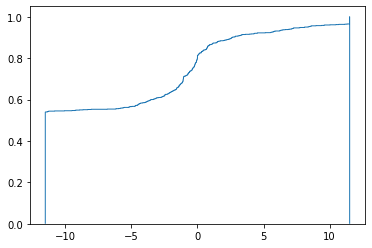

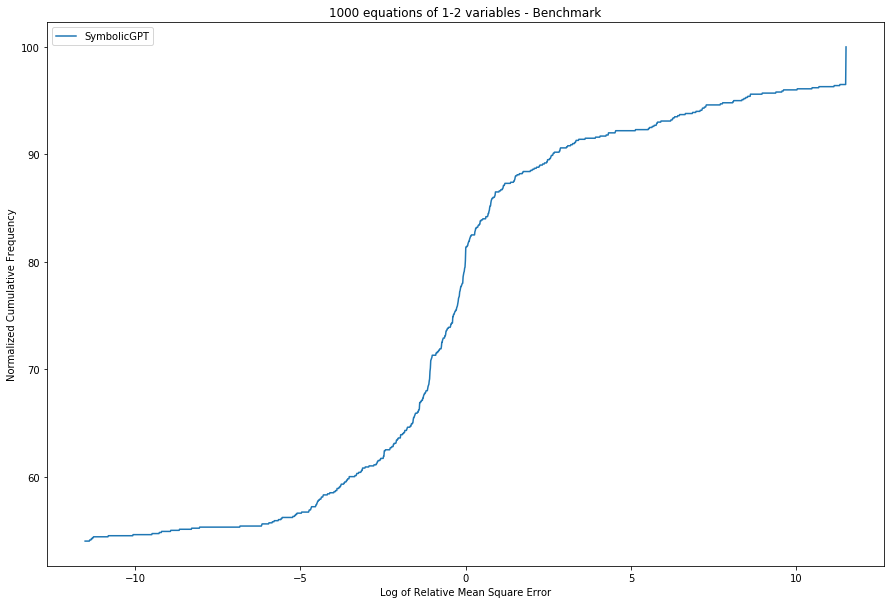

In [25]:
# plot the error frequency for model comparison
from matplotlib import pyplot as plt
num_eqns = len(resultDict[fName]['SymbolicGPT'])
num_vars = pconf.numberofVars

models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key])==num_eqns)
lists_of_error_scores = [resultDict[fName][key] for key in models if len(resultDict[fName][key])==num_eqns]
linestyles = ["-","dashdot","dotted","--"]

eps = 0.00001
y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                   label=models,
                   cumulative=True, 
                   histtype="step", 
                   bins=2000, 
                   density=True,
                   log=False)
y = np.expand_dims(y,0)
plt.figure(figsize=(15, 10))

for idx, m in enumerate(models): 
    plt.plot(x[:-1], 
           y[idx] * 100, 
           linestyle=linestyles[idx], 
           label=m)

plt.legend(loc="upper left")
plt.title("{} equations of {} variables - Benchmark".format(num_eqns, num_vars))
plt.xlabel("Log of Relative Mean Square Error")
plt.ylabel("Normalized Cumulative Frequency")

name = '{}.png'.format(fName.split('.txt')[0])
plt.savefig(name)

In [91]:
# benchmarks
import csv
benchmarkPath = './benchmark/dsr-benchmark-data/'
dataPoints = glob.glob(benchmarkPath+'*.csv')
NGUYEN2Eq = {
           '1':'x1^3+x1^2+x1',
           '2':'x1^4+x1^3+x1^2+x1',
           '3':'x1^5+x1^4+x1^3+x1^2+x1',
           '4':'x1^6+x1^5+x1^4+x1^3+x1^2+x1',
           '5':'sin(x1^2)*cos(x1)-1',
           '6':'sin(x1)+sin(x1+x1^2)',
           '7':'log(x1+1)+log(x1^2+1)',
           '8':'sqrt(x1)',
           '9':'sin(x1)+sin(x2^2)',
           '10':'2*sin(x1)*cos(x2)',
           '11':'x1^x2',
           '12':'x1^4-x1^3+x2^2/2-x2',}
for dataPoint in dataPoints: 
    key = dataPoint.split('\\')[-1].split('Nguyen-')[-1].split('_')[0]
    if not key in NGUYEN2Eq.keys():
        continue
    target = NGUYEN2Eq[key]
    with open(dataPoint, newline='\n') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        pointsList = [([eval(x) for x in p[:-1]],eval(p[-1])) for i,p in enumerate(reader) if i < numPoints]
        
        # initialized the input variable with start token <
        inputs = torch.tensor([[train_dataset.stoi['<']]]).to(trainer.device)
        
        # extract points from the input sequence
        points = torch.zeros(numVars+numYs, numPoints)
        for idx, xy in enumerate(pointsList):
            x = xy[0] + [0]*(max(numVars-len(xy[0]),0)) # padding
            y = [xy[1]] if type(xy[1])== float else xy[1]
            y = y + [0]*(max(numYs-len(y),0)) # padding
            p = x+y # because it is only one point 
            p = torch.tensor(p)
            #replace nan and inf
            p = torch.nan_to_num(p, nan=0.0, 
                                 posinf=train_dataset.threshold[1], 
                                 neginf=train_dataset.threshold[0])
            p[p>train_dataset.threshold[1]] = train_dataset.threshold[1] # clip the upper bound
            p[p<train_dataset.threshold[0]] = train_dataset.threshold[0] # clip the lower bound
            points[:,idx] = p
            
        points = points.unsqueeze(0).to(trainer.device)
        outputsHat = sample(model, inputs, blockSize, points=points,
                      temperature=1.0, sample=True, 
                      top_k=40)[0]
        
        # filter out predicted
        predicted = ''.join([train_dataset.itos[int(i)] for i in outputsHat])
        predicted = predicted.strip(train_dataset.paddingToken).split('>')
        predicted = predicted[0] if len(predicted[0])>=1 else predicted[1]
        predicted = predicted.strip('<').strip(">")

        print('NGUYEN-{} --> Target:{}\nPredicted:{}\n'.format(key, target, predicted))

NGUYEN-10 --> Target:2*sin(x1)*cos(x2)
Predicted:log(abs(1.0*x1**2+1.0*x1))

NGUYEN-11 --> Target:x1^x2
Predicted:log(abs(1.0*x1))+sin(1.0*x1)

NGUYEN-12 --> Target:x1^4-x1^3+x2^2/2-x2
Predicted:log(abs(1.0*x1))

NGUYEN-1 --> Target:x1^3+x1^2+x1
Predicted:1.0*x1+sqrt(abs(1.0*x1))

NGUYEN-2 --> Target:x1^4+x1^3+x1^2+x1
Predicted:2.0*x1

NGUYEN-3 --> Target:x1^5+x1^4+x1^3+x1^2+x1
Predicted:4.0*x1

NGUYEN-4 --> Target:x1^6+x1^5+x1^4+x1^3+x1^2+x1
Predicted:exp(sqrt(abs(1.0*x1))*exp(1.0*x1))

NGUYEN-5 --> Target:sin(x1^2)*cos(x1)-1
Predicted:log(abs(1.0*x1))

NGUYEN-6 --> Target:sin(x1)+sin(x1+x1^2)
Predicted:1.0*x1+sqrt(abs(1.0*x1))

NGUYEN-7 --> Target:log(x1+1)+log(x1^2+1)
Predicted:1.0*x1*sin(1.0*x1)

NGUYEN-8 --> Target:sqrt(x1)
Predicted:sqrt(abs(1.0*x1))

NGUYEN-9 --> Target:sin(x1)+sin(x2^2)
Predicted:2.0*x1



In [84]:
points

tensor([[[0.1907, 0.5118, 0.8858, 0.4192, 0.7256, 0.0788, 0.1415, 0.9209,
          0.4438, 0.8249, 0.6300, 0.2129, 0.8031, 0.0559, 0.8503, 0.6839,
          0.6319, 0.5746, 0.9190, 0.5637],
         [0.4378, 0.9111, 0.9831, 0.7158, 0.8818, 0.7789, 0.1672, 0.7350,
          0.6094, 0.3830, 0.1312, 0.8180, 0.2909, 0.3495, 0.6267, 0.0654,
          0.5282, 0.6727, 0.0723, 0.3227],
         [0.3801, 1.2277, 1.5974, 0.8973, 1.3651, 0.6488, 0.1690, 1.3105,
          0.7923, 0.8807, 0.6064, 0.8316, 0.8040, 0.1778, 1.1342, 0.6361,
          0.8660, 0.9807, 0.8002, 0.6383]]], device='cuda:0')